In [1]:
# packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc, classification_report
from sklearn.linear_model import LogisticRegression
import pickle


In [2]:
# load data
train_ads = pd.read_csv('train_data_ads.csv.zip', compression='zip')

In [3]:
categorical_features = train_ads.select_dtypes(include=['object', 'category']).columns
numerical_features = train_ads.select_dtypes(include=[np.number]).columns

print(f"Categorical features: {list(categorical_features)}")
print(f"Numerical features: {list(numerical_features)}")
print(train_ads.gender.value_counts())

Categorical features: ['ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003', 'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003', 'u_newsCatInterestsST']
Numerical features: ['log_id', 'label', 'user_id', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size', 'net_type', 'task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id', 'inter_type_cd', 'slot_id', 'site_id', 'spread_app_id', 'hispace_app_tags', 'app_second_class', 'app_score', 'pt_d', 'u_refreshTimes', 'u_feedLifeCycle']
2    5946172
4    1178908
3     550437
Name: gender, dtype: int64


In [4]:
X = train_ads.drop(['gender'], axis=1)
y = train_ads['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [8]:
# classifier and grid search params
lr = LogisticRegression(random_state=1, class_weight='balanced')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ad_click_list_v001'])  # One-hot encode 
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga'],
    'classifier__C': np.arange(0.1, 1, 0.1),
    'classifier__warm_start': [True],
    'classifier__max_iter': [1000]
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3
)

In [9]:
# run this cell to fit grid search on sgd important features
features_sgd =  ['app_score', 'app_second_class', 'series_group', 'emui_dev', 'series_dev']
grid_search.fit(X_train[features_sgd], y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# run this cell to fit grid search on just ad click list v001
features_adclick = ['ad_click_list_v001']
grid_search.fit(X_train[features_adclick], y_train)

In [ ]:
# run this cell to fit grid search on categorical and ad click list v001
features_cat_adclick = ['city', 'app_score', 'age', 'ad_click_list_v001']
grid_search.fit(X_train[features_cat_adclick], y_train)

In [ ]:
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test[features_adclick]) # change features based on which ones used for training
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")

Precision for 2: [0.79011675 0.79012085 0.79015584 ... 1.         1.         1.        ]
Recall for 2: [1.00000000e+00 9.99999440e-01 9.99999440e-01 ... 5.80601303e-04
 2.99827893e-04 0.00000000e+00]
Precision for 3: [0.08076355 0.08077195 0.08077361 ... 1.         1.         1.        ]
Recall for 3: [1.00000000e+00 9.99993948e-01 9.99993948e-01 ... 8.89620489e-04
 4.78095365e-04 0.00000000e+00]
Precision for 4: [0.15912248 0.15912812 0.15913322 ... 1.         1.         1.        ]
Recall for 4: [1.         0.99999717 0.99999717 ... 0.00213278 0.00115561 0.        ]


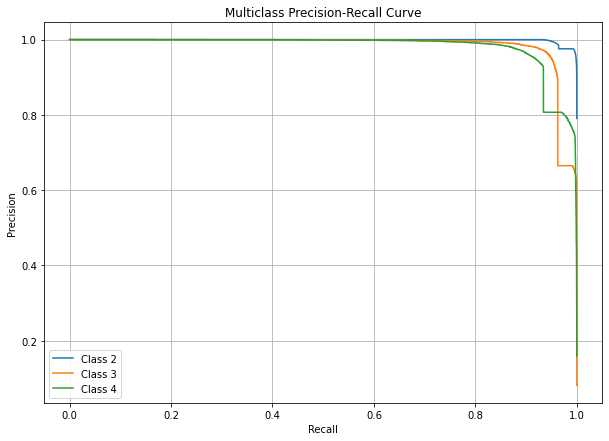

In [9]:
# Binarize the labels (One-vs-Rest) for precision-recall calculation
y_test_bin = label_binarize(y_test, classes=[2, 3, 4])

# Step 4: Get predicted probabilities for each class
y_prob = best_model.predict_proba(X_test[features_adclick])

# Step 5: Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 7))

for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    print(f'Precision for {i+2}: {precision}')
    print(f'Recall for {i+2}: {recall}')
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=plt.gca(), name=f'Class {i+2}')

# Step 6: Add plot details
plt.title('Multiclass Precision-Recall Curve')
plt.grid(True)
plt.show()

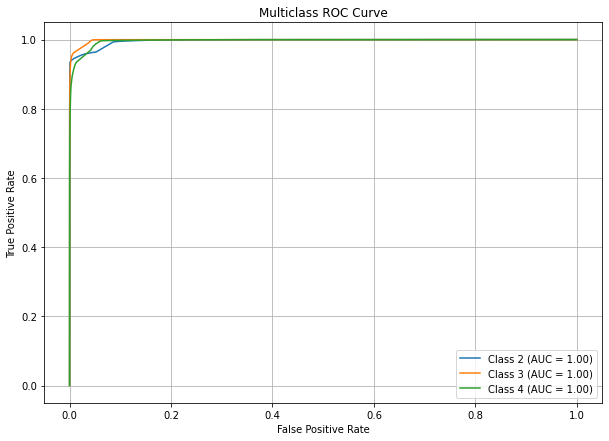

In [10]:
plt.figure(figsize=(10, 7))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i+2}')
    display.plot(ax=plt.gca())

# Step 7: Add plot details
plt.title('Multiclass ROC Curve')
plt.grid(True)
plt.show()

In [11]:
y_pred = best_model.predict(X_test[features_adclick])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      0.95      0.97   1784357
           3       0.95      0.95      0.95    165239
           4       0.80      0.98      0.88    353060

    accuracy                           0.95   2302656
   macro avg       0.91      0.96      0.93   2302656
weighted avg       0.96      0.95      0.96   2302656

